# Conclusions using CD 3.1 analysis of lipidomics data

### Using Fligner-Killeen non-parametric test for difference in variance between two samples:

1. 52 features showed significant difference in variance after FDR correciton 
    - 43 lipids
    - 9 metabolites
2. 11 features showed Fasted variance > Random variance 
    - (9 metabolites, 2 early eluting lipids)    
3. 41 features showed Random variance > Fasted variance 
    - All were lipids
3. TGs represent vast majority of all 52 features

In [162]:
import ast
import random
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2, ttest_ind_from_stats, fligner, levene, f

In [157]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

fasted = data[fbg_cols]  # fasted
randomfed = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

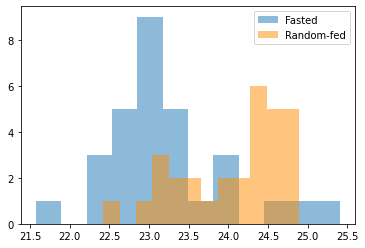

In [178]:
rand = random.sample(data.index.to_list(), 1)

plt.hist(fasted.loc[rand].T, bins=12, alpha=0.5, label='Fasted')
plt.hist(randomfed.loc[rand].T, bins=12, color='darkorange', alpha=0.5, label='Random-fed')
plt.legend()
# f = data.loc[rand, fbg_cols].T.hist(bins=15)
# data.loc[rand, rbg_cols].T.hist(bins=15)

array([[<AxesSubplot:title={'center':'l_130'}>]], dtype=object)

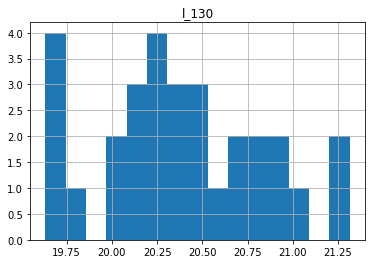

In [165]:
data[rbg_cols].sample(1).T.hist(bins=15)

## Tests for differences in variance: 
1. F-test (parametric), two samples only. Very sensitive to non-normality 
### F-test is therefore not good for our data
2. Levene's test (parametric), less sensitive to non-normality
3. Fligner-Killeen (non-parametric)


In [208]:
fasted.columns = fasted.columns.str.strip('_FBG')
randomfed.columns = randomfed.columns.str.strip('_RBG')
result = {}
for i, row in fasted.iterrows():
    f_row = fasted.loc[i]
    r_row = randomfed.loc[i]
    f_var = f_row.var()
    r_var = r_row.var()
    
    fk = fligner(f_row, r_row)[1] 
    lev = levene(f_row, r_row)[1]
#     F = r_var / f_var   # https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python
#     df1 = len(f_row)
#     df2 = len(r_row)
#     ftest = f.sf(F, df1, df2)
    
    result[i] = {}
    result[i]['q_fk'] = fk
    result[i]['q_lev'] = lev
#     result[i]['q_f'] = ftest
    result[i]['fvar'] = f_var
    result[i]['rvar'] = r_var
result = pd.DataFrame(result).T
result['q_fk'] = fdrcorrection(result['q_fk'])[1]
result['q_lev'] = fdrcorrection(result['q_lev'])[1]
# result['q_f'] = fdrcorrection(result['q_f'])[1]

In [209]:
result = result.join(data[['Unique ID', 'Type', 'Proposed ID', 'Compound Class', 'm/z', 'RT [min]', 'Area (Max.)']])
result

,q_fk,q_lev,fvar,rvar,Unique ID,Type,Proposed ID,Compound Class,m/z,RT [min],Area (Max.)
l_0,0.752413,0.948568,0.478701,0.201845,unknown_679.05463_0.536,lipid,unknown,unknown,679.05463,0.536,24.521584
l_1,0.968158,0.997443,0.749760,0.614112,unknown_641.1087_0.537,lipid,unknown,unknown,641.10870,0.537,25.718750
l_2,0.789164,0.929867,0.459299,0.408486,unknown_951.15973_0.541,lipid,unknown,unknown,951.15973,0.541,24.948650
l_3,0.784607,0.879690,0.345148,0.210121,unknown_329.03067_0.542,lipid,unknown,unknown,329.03067,0.542,28.102881
l_4,0.836833,0.980672,0.531456,0.358950,unknown_969.13147_0.544,lipid,unknown,unknown,969.13147,0.544,24.016735
...,...,...,...,...,...,...,...,...,...,...,...
m_169,0.974821,0.975012,0.046844,0.040133,unknown_174.00102_9.94,metabolite,unknown,unknown,174.00102,9.940,25.488336
m_213,0.661431,0.789423,3.802876,3.342286,unknown_187.04097_9.971,metabolite,unknown,unknown,187.04097,9.971,25.075584
m_24,0.721181,0.763848,0.283294,0.204059,DL-Lactic Acid_89.02331_9.99,metabolite,DL-Lactic Acid,CA,89.02331,9.990,28.683584
m_505,0.775398,0.786793,2.243004,1.544469,unknown_313.051_9.991,metabolite,unknown,unknown,313.05100,9.991,22.573809


<AxesSubplot:>

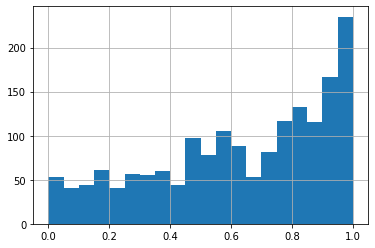

In [210]:
result['q_fk'].hist(bins=20)

In [252]:
result[result['q_fk'] < 0.05]

,q_fk,q_lev,fvar,rvar,Unique ID,Type,Proposed ID,Compound Class,m/z,RT [min],Area (Max.)
l_144,0.017252,0.008335,0.179326,1.200745,unknown_585.48676_5.159,lipid,unknown,unknown,585.48676,5.159,24.111644
l_244,0.045969,0.018077,0.225096,0.047274,unknown_589.51953_7.992,lipid,unknown,unknown,589.51953,7.992,21.056630
l_291,0.020715,0.040293,0.244294,0.021680,unknown_1025.55762_8.335,lipid,unknown,unknown,1025.55762,8.335,20.365059
l_303,0.009875,0.003638,0.679255,2.569783,unknown_822.60199_8.434,lipid,unknown,unknown,822.60199,8.434,25.288762
l_394,0.025591,0.009123,0.654965,2.678695,unknown_682.54065_9.164,lipid,unknown,unknown,682.54065,9.164,22.416815
l_648,0.015681,0.011439,0.367605,2.178896,unknown_988.73981_12.798,lipid,unknown,unknown,988.73981,12.798,21.918177
l_657,0.002025,0.000270,0.398845,3.195315,TG_20:5_22:6_22:6_1014.755_13.093,lipid,TG 20:5_22:6_22:6,TG,1014.75500,13.093,23.129639
l_669,0.002241,0.000118,0.620553,4.296688,unknown_1081.79688_13.387,lipid,unknown,unknown,1081.79688,13.387,21.383977
l_670,0.005460,0.002363,0.764444,4.713124,TG_22:6_22:6_22:6_1040.77014_13.389,lipid,TG 22:6_22:6_22:6,TG,1040.77014,13.389,23.066720
l_678,0.009540,0.003638,0.193606,2.939388,unknown_1031.78162_13.497,lipid,unknown,unknown,1031.78162,13.497,20.787981


In [253]:
result.loc[(result['q_fk'] < 0.05) & (result['fvar'] > result['rvar'])]

,q_fk,q_lev,fvar,rvar,Unique ID,Type,Proposed ID,Compound Class,m/z,RT [min],Area (Max.)
l_244,0.045969,0.018077,0.225096,0.047274,unknown_589.51953_7.992,lipid,unknown,unknown,589.51953,7.992,21.056630
l_291,0.020715,0.040293,0.244294,0.021680,unknown_1025.55762_8.335,lipid,unknown,unknown,1025.55762,8.335,20.365059
m_308,0.044461,0.055092,0.443248,0.118588,unknown_242.07918_11.649,metabolite,unknown,unknown,242.07918,11.649,24.235517
m_79,0.009540,0.018077,3.501848,0.273751,unknown_201.0218_2.13,metabolite,unknown,unknown,201.02180,2.130,26.942709
m_265,0.035722,0.082345,0.988460,0.327648,unknown_609.32973_2.284,metabolite,unknown,unknown,609.32973,2.284,24.658959
m_53,0.035454,0.063081,0.878139,0.231567,unknown_568.33972_2.288,metabolite,unknown,unknown,568.33972,2.288,27.529410
m_485,0.035332,0.102835,1.103136,0.415356,unknown_626.34544_2.293,metabolite,unknown,unknown,626.34544,2.293,22.782587
m_653,0.009660,0.013647,1.155712,0.227040,unknown_626.39288_2.306,metabolite,unknown,unknown,626.39288,2.306,21.310668
m_269,0.007286,0.018077,0.983347,0.219498,unknown_585.3298_2.379,metabolite,unknown,unknown,585.32980,2.379,24.598662
m_66,0.012068,0.008335,0.836893,0.128300,unknown_544.33978_2.383,metabolite,unknown,unknown,544.33978,2.383,27.227068


In [312]:
_iter = iter(result[result['q_fk'] < 0.05].index)

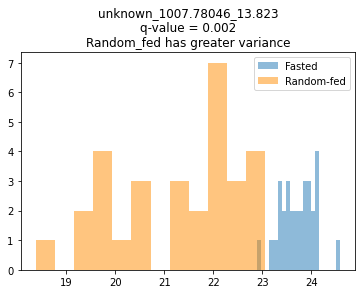

In [325]:
i = next(_iter)

plt.hist(fasted.loc[i].T, bins=20, alpha=0.5, label='Fasted',)
plt.hist(randomfed.loc[i].T, bins=12, color='darkorange', alpha=0.5, label='Random-fed')
plt.legend()
greater_var = ('Random_fed' if result.loc[i, 'rvar'] > result.loc[i, 'fvar'] else 'Fasted')

plt.title(data.loc[i, 'Unique ID'] + '\nq-value = ' + \
          str(round(result.loc[i, 'q_fk'], 4)) + '\n' + \
          greater_var + ' has greater variance');

(0.0, 0.05)

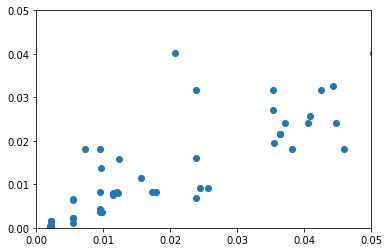

In [213]:
plt.scatter(result['q_fk'], result['q_lev'])
plt.xlim(0, 0.05)
plt.ylim(0, 0.05)

# Below is the Wilcoxon analysis, which doesn't tell whether variance is different, only if centers are different. 

In [59]:
wr = defaultdict(lambda: {})
all_paired = (rn - fn).join((ri - fi)).join((rd - fd))
for bg_type, df in [('n', rn - fn), ('i', ri - fi), ('d', rd - fd), ('all', all_paired)]:
    for i, row in df.iterrows():
        w = wilcoxon(row, alternative='greater')
        wr[i][bg_type+'_r_greater_var'] = w[1]
        w = wilcoxon(row, alternative='less')
#         print(row)
#         print(row * -1)
        wr[i][bg_type+'_f_greater_var'] = w[1]
w = pd.DataFrame(wr).T
for col in ['n_r_greater_var', 'i_r_greater_var', 'd_r_greater_var', 'all_r_greater_var', 
            'n_f_greater_var', 'i_f_greater_var', 'd_f_greater_var', 'all_f_greater_var']:
    w[col + 'fdr'] = fdrcorrection(w[col])[1]
w = w.filter(regex='fdr')

In [60]:
w.sample(30)

,n_r_greater_varfdr,i_r_greater_varfdr,d_r_greater_varfdr,all_r_greater_varfdr,n_f_greater_varfdr,i_f_greater_varfdr,d_f_greater_varfdr,all_f_greater_varfdr
m_126,1.000000,1.000000,0.670142,0.999999,0.083285,0.321808,1.000000,0.194289
l_189,1.000000,1.000000,0.467660,0.999999,0.339731,0.880289,1.000000,0.880680
m_630,0.281087,0.000902,0.015948,0.000027,1.000000,1.000000,1.000000,0.999999
l_187,1.000000,1.000000,0.368114,0.999999,0.443822,0.849449,1.000000,0.696958
m_85,1.000000,1.000000,1.000000,0.999999,0.443822,0.406588,0.105408,0.020746
m_500,0.281087,0.849551,0.766874,0.442952,1.000000,1.000000,1.000000,0.999999
l_805,0.596999,0.240017,0.419227,0.097080,1.000000,1.000000,1.000000,0.999999
l_876,1.000000,0.000902,0.056785,0.001166,0.443822,1.000000,1.000000,0.999999
l_244,0.281087,0.000473,0.009979,0.000016,1.000000,1.000000,1.000000,0.999999
l_630,0.708783,0.134140,0.190927,0.016696,1.000000,1.000000,1.000000,0.999999


<AxesSubplot:>

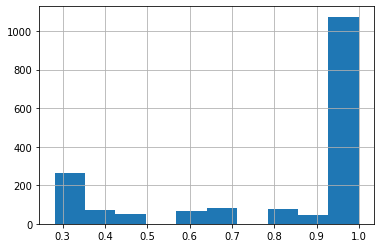

In [63]:
w['n_r_greater_varfdr'].hist()

In [230]:
for col in ['n_f_greater_varfdr', 'i_f_greater_varfdr', 'd_f_greater_varfdr', 'all_f_greater_varfdr']:
    print(col, w.loc[w[col] < 0.025].shape[0])

n_f_greater_varfdr 0
i_f_greater_varfdr 321
d_f_greater_varfdr 0
all_f_greater_varfdr 352


In [227]:
for col in ['n_r_greater_varfdr', 'i_r_greater_varfdr', 'd_r_greater_varfdr', 'all_r_greater_varfdr']:
    print(col, w.loc[w[col] < 0.025].shape[0])

n_r_greater_varfdr 0
i_r_greater_varfdr 481
d_r_greater_varfdr 461
all_r_greater_varfdr 591


In [198]:
w.loc[(w[['nfdr', 'ifdr', ]] < 0.05).any(axis=1), ['ifdr', 'dfdr']]

,ifdr,dfdr
l_59,0.035847,0.156116
l_62,0.000902,0.044466
l_63,0.000399,0.009979
l_64,0.000399,0.009979
l_67,0.041824,0.096810
...,...,...
m_340,0.012686,0.056785
m_616,0.002011,0.009979
m_557,0.000473,0.009979
m_213,0.012686,0.156116


In [206]:
ifdr = set(w.loc[w['ifdr'] < 0.025].index)
dfdr = set(w.loc[w['dfdr'] < 0.025].index)
idfdr = set(w.loc[(w[['ifdr', 'dfdr']] < 0.025).any(axis=1)].index)

In [212]:
print('number of metabolites found in only one significance list')
print(len(ifdr.symmetric_difference(dfdr)))
print(len(idfdr.symmetric_difference(dfdr)))
print(len(idfdr.symmetric_difference(ifdr)))


number of metabolites found in only one significance list
150
85
65


<AxesSubplot:>

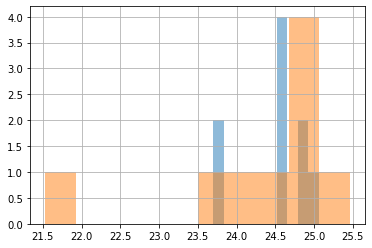

In [184]:
rd.loc['l_1'].hist(alpha=0.5)
fd.loc['l_1'].hist(alpha=0.5)

In [179]:
random = np.array([10, 11, 12, 13, 12, ])  # Random
fasted = np.array([5,  4,  3,  3,  3,  ])  # Fasted

w, p = wilcoxon(random - fasted, alternative='greater')
w, p
# Here, random is clearly bigger, so it has a significant p-value

(15.0, 0.03125)

In [90]:
tt = {}
for (i, rowf), (j, rowr) in zip(fn.iterrows(), rn.iterrows()):
    t = mannwhitneyu(rowf, rowr, alternative='two-sided')
#     print(t)
    tt[i] = {'n': t.pvalue}

for (i, rowf), (j, rowr) in zip(fi.iterrows(), ri.iterrows()):
    t = mannwhitneyu(rowf, rowr, alternative='two-sided')
#     print(t)
    tt[i]['i'] = t.pvalue

for (i, rowf), (j, rowr) in zip(fd.iterrows(), rd.iterrows()):
    t = mannwhitneyu(rowf, rowr, alternative='two-sided')
#     print(t)
    tt[i]['d'] = t.pvalue


MannwhitneyuResult(statistic=56.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statistic=105.0, pvalue=0.7715511878155722)
MannwhitneyuResult(statistic=83.0, pvalue=0.22902896662469463)
MannwhitneyuResult(statistic=79.0, pvalue=0.17106923105635186)
MannwhitneyuResult(statistic=90.0, pvalue=0.3614963660708982)
MannwhitneyuResult(statistic=115.0, pvalue=0.9338864180775845)
MannwhitneyuResult(statistic=122.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=114.0, pvalue=0.9669147771731937)
MannwhitneyuResult(statistic=117.0, pvalue=0.8682259903524354)
MannwhitneyuResult(statistic=125.0, pvalue=0.6186695570822622)
MannwhitneyuResult(statistic=109.0, pvalue=0.9009714934164412)
MannwhitneyuResult(statistic=94.0, pvalue=0.4553018964198552)
MannwhitneyuResult(statistic=153.0, pvalue=0.09709106759647709)
MannwhitneyuResult(statistic=134.0, pvalue=0.38373262766250305)
MannwhitneyuResult(statistic=96.0, pvalue=0.506914933812496)
MannwhitneyuResult(statistic=76.0, pvalue=0.135382110045

MannwhitneyuResult(statistic=0.0, pvalue=3.3918213908250945e-06)
MannwhitneyuResult(statistic=145.0, pvalue=0.1844100692216365)
MannwhitneyuResult(statistic=0.0, pvalue=3.3918213908250945e-06)
MannwhitneyuResult(statistic=56.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statistic=54.0, pvalue=0.01614027989360373)
MannwhitneyuResult(statistic=5.0, pvalue=9.073400856319234e-06)
MannwhitneyuResult(statistic=0.0, pvalue=3.3918213908250945e-06)
MannwhitneyuResult(statistic=112.0, pvalue=1.0)
MannwhitneyuResult(statistic=177.0, pvalue=0.00794033626424658)
MannwhitneyuResult(statistic=76.0, pvalue=0.13538211004560674)
MannwhitneyuResult(statistic=17.0, pvalue=8.13402807598356e-05)
MannwhitneyuResult(statistic=72.0, pvalue=0.09709106759647709)
MannwhitneyuResult(statistic=7.0, pvalue=1.3294722762606463e-05)
MannwhitneyuResult(statistic=3.0, pvalue=6.151638741096579e-06)
MannwhitneyuResult(statistic=73.0, pvalue=0.10573920209087935)
MannwhitneyuResult(statistic=1.0, pvalue=4.14322009753753

MannwhitneyuResult(statistic=6.0, pvalue=1.0992164801504738e-05)
MannwhitneyuResult(statistic=1.0, pvalue=4.143220097537536e-06)
MannwhitneyuResult(statistic=19.0, pvalue=0.00011457127866286101)
MannwhitneyuResult(statistic=182.0, pvalue=0.004209946028667896)
MannwhitneyuResult(statistic=11.0, pvalue=2.7983495853192978e-05)
MannwhitneyuResult(statistic=31.0, pvalue=0.0007802051762911044)
MannwhitneyuResult(statistic=12.0, pvalue=3.356755084154065e-05)
MannwhitneyuResult(statistic=19.0, pvalue=0.00011457127866286101)
MannwhitneyuResult(statistic=70.0, pvalue=0.08149464839345506)
MannwhitneyuResult(statistic=9.0, pvalue=1.9351827710442478e-05)
MannwhitneyuResult(statistic=66.0, pvalue=0.05639236422683157)
MannwhitneyuResult(statistic=135.0, pvalue=0.3614963660708982)
MannwhitneyuResult(statistic=78.0, pvalue=0.15846460599820356)
MannwhitneyuResult(statistic=6.0, pvalue=1.0992164801504738e-05)
MannwhitneyuResult(statistic=117.0, pvalue=0.8682259903524354)
MannwhitneyuResult(statistic=152.

MannwhitneyuResult(statistic=222.0, pvalue=6.151638741096579e-06)
MannwhitneyuResult(statistic=115.0, pvalue=0.9338864180775845)
MannwhitneyuResult(statistic=123.0, pvalue=0.6783024655972324)
MannwhitneyuResult(statistic=40.0, pvalue=0.0028226386759533724)
MannwhitneyuResult(statistic=186.0, pvalue=0.0024626042007544527)
MannwhitneyuResult(statistic=211.0, pvalue=4.8063230506309336e-05)
MannwhitneyuResult(statistic=217.0, pvalue=1.6053092802023668e-05)
MannwhitneyuResult(statistic=213.0, pvalue=3.356755084154065e-05)
MannwhitneyuResult(statistic=208.0, pvalue=8.13402807598356e-05)
MannwhitneyuResult(statistic=208.0, pvalue=8.13402807598356e-05)
MannwhitneyuResult(statistic=211.0, pvalue=4.8063230506309336e-05)
MannwhitneyuResult(statistic=208.0, pvalue=8.13402807598356e-05)
MannwhitneyuResult(statistic=51.0, pvalue=0.01140098291155517)
MannwhitneyuResult(statistic=94.0, pvalue=0.4553018964198552)
MannwhitneyuResult(statistic=169.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statis

MannwhitneyuResult(statistic=122.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=124.0, pvalue=0.6482039260122094)
MannwhitneyuResult(statistic=123.0, pvalue=0.6783024655972324)
MannwhitneyuResult(statistic=109.0, pvalue=0.9009714934164412)
MannwhitneyuResult(statistic=145.0, pvalue=0.1844100692216365)
MannwhitneyuResult(statistic=148.0, pvalue=0.14657603430900068)
MannwhitneyuResult(statistic=121.0, pvalue=0.7400217511938185)
MannwhitneyuResult(statistic=134.0, pvalue=0.38373262766250305)
MannwhitneyuResult(statistic=112.0, pvalue=1.0)
MannwhitneyuResult(statistic=122.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=86.0, pvalue=0.28084201086629845)
MannwhitneyuResult(statistic=211.0, pvalue=4.8063230506309336e-05)
MannwhitneyuResult(statistic=103.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=122.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=79.0, pvalue=0.17106923105635186)
MannwhitneyuResult(statistic=54.0, pvalue=0.01614027989360373)
M

MannwhitneyuResult(statistic=24.0, pvalue=0.00026216888813650863)
MannwhitneyuResult(statistic=36.0, pvalue=0.001619713575230349)
MannwhitneyuResult(statistic=15.0, pvalue=5.737063008488556e-05)
MannwhitneyuResult(statistic=34.0, pvalue=0.0012151954178690621)
MannwhitneyuResult(statistic=22.0, pvalue=0.00018919298065443355)
MannwhitneyuResult(statistic=26.0, pvalue=0.0003609347195741741)
MannwhitneyuResult(statistic=23.0, pvalue=0.0002228932910846752)
MannwhitneyuResult(statistic=24.0, pvalue=0.00026216888813650863)
MannwhitneyuResult(statistic=18.0, pvalue=9.661535870152319e-05)
MannwhitneyuResult(statistic=28.0, pvalue=0.0004936885181146133)
MannwhitneyuResult(statistic=41.0, pvalue=0.0032301435955866646)
MannwhitneyuResult(statistic=48.0, pvalue=0.00794033626424658)
MannwhitneyuResult(statistic=73.0, pvalue=0.10573920209087935)
MannwhitneyuResult(statistic=39.0, pvalue=0.0024626042007544527)
MannwhitneyuResult(statistic=77.0, pvalue=0.14657603430900068)
MannwhitneyuResult(statistic=

MannwhitneyuResult(statistic=128.0, pvalue=0.5338294217441396)
MannwhitneyuResult(statistic=112.0, pvalue=1.0)
MannwhitneyuResult(statistic=136.0, pvalue=0.3400858902842717)
MannwhitneyuResult(statistic=89.0, pvalue=0.3400858902842717)
MannwhitneyuResult(statistic=129.0, pvalue=0.506914933812496)
MannwhitneyuResult(statistic=124.0, pvalue=0.6482039260122094)
MannwhitneyuResult(statistic=117.0, pvalue=0.8682259903524354)
MannwhitneyuResult(statistic=124.0, pvalue=0.6482039260122094)
MannwhitneyuResult(statistic=126.0, pvalue=0.5897385933186072)
MannwhitneyuResult(statistic=132.0, pvalue=0.43064798984807773)
MannwhitneyuResult(statistic=132.0, pvalue=0.43064798984807773)
MannwhitneyuResult(statistic=137.0, pvalue=0.3195059648919748)
MannwhitneyuResult(statistic=88.0, pvalue=0.3195059648919748)
MannwhitneyuResult(statistic=85.0, pvalue=0.26275304114766074)
MannwhitneyuResult(statistic=126.0, pvalue=0.5897385933186072)
MannwhitneyuResult(statistic=131.0, pvalue=0.4553018964198552)
Mannwhit

MannwhitneyuResult(statistic=85.0, pvalue=0.26275304114766074)
MannwhitneyuResult(statistic=83.0, pvalue=0.22902896662469463)
MannwhitneyuResult(statistic=53.0, pvalue=0.014396852751179462)
MannwhitneyuResult(statistic=56.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statistic=37.0, pvalue=0.0018654646290708888)
MannwhitneyuResult(statistic=118.0, pvalue=0.8357050269952793)
MannwhitneyuResult(statistic=29.0, pvalue=0.0005759812107616887)
MannwhitneyuResult(statistic=31.0, pvalue=0.0007802051762911044)
MannwhitneyuResult(statistic=47.0, pvalue=0.007016199234239618)
MannwhitneyuResult(statistic=44.0, pvalue=0.004794758682161994)
MannwhitneyuResult(statistic=56.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statistic=50.0, pvalue=0.010121802247772722)
MannwhitneyuResult(statistic=136.0, pvalue=0.3400858902842717)
MannwhitneyuResult(statistic=5.0, pvalue=9.073400856319234e-06)
MannwhitneyuResult(statistic=9.0, pvalue=1.9351827710442478e-05)
MannwhitneyuResult(statistic=27.0, pvalu

MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=1.0, pvalue=0.0005736335109885613)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=1.0, pvalue=0.0005736335109885613)
MannwhitneyuResult(statistic=1.0, pvalue=0.0005736335109885613)
MannwhitneyuResult(statistic=48.0, pvalue=0.5364994693194564)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=3.0, pvalue=0.0010862466258220339)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=66.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=45.0, pvalue=0.7239320396139757)
MannwhitneyuResult(statistic=0.0, pval

MannwhitneyuResult(statistic=2.0, pvalue=0.0007922682038502908)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=5.0, pvalue=0.0019976900972723025)
MannwhitneyuResult(statistic=43.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=22.0, pvalue=0.11196135426374831)
MannwhitneyuResult(statistic=81.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=64.0, pvalue=0.04226010608395664)
MannwhitneyuResult(statistic=38.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=14.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=76.0, pvalue=0.0019976900972723025)
MannwhitneyuResult(statistic=71.0, pvalue=0.008071487425268009)
MannwhitneyuResult(statistic=67.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=62.0, pvalue=0.06368977513662868)
MannwhitneyuResult(statistic=12.0, pvalue=0.013418657920497472)
MannwhitneyuResult(statistic=14.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=10.0, pvalue=0.0

MannwhitneyuResult(statistic=5.0, pvalue=0.0019976900972723025)
MannwhitneyuResult(statistic=23.0, pvalue=0.1333202155896274)
MannwhitneyuResult(statistic=12.0, pvalue=0.013418657920497472)
MannwhitneyuResult(statistic=62.0, pvalue=0.06368977513662868)
MannwhitneyuResult(statistic=25.0, pvalue=0.18532630419857943)
MannwhitneyuResult(statistic=31.0, pvalue=0.42677673653298365)
MannwhitneyuResult(statistic=60.0, pvalue=0.0933976745287926)
MannwhitneyuResult(statistic=22.0, pvalue=0.11196135426374831)
MannwhitneyuResult(statistic=81.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=74.0, pvalue=0.003568628436933387)
MannwhitneyuResult(statistic=70.0, pvalue=0.010444271101370226)
MannwhitneyuResult(statistic=56.0, pvalue=0.18532630419857943)
MannwhitneyuResult(statistic=74.0, pvalue=0.003568628436933387)
MannwhitneyuResult(statistic=47.0, pvalue=0.5962416305866567)
MannwhitneyuResult(statistic=41.0, pvalue=1.0)
MannwhitneyuResult(statistic=43.0, pvalue=0.859819205054158)
Mannw

MannwhitneyuResult(statistic=41.0, pvalue=1.0)
MannwhitneyuResult(statistic=58.0, pvalue=0.1333202155896274)
MannwhitneyuResult(statistic=43.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=42.0, pvalue=0.9296365245070707)
MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
MannwhitneyuResult(statistic=32.0, pvalue=0.47992869214595724)
MannwhitneyuResult(statistic=12.0, pvalue=0.013418657920497472)
MannwhitneyuResult(statistic=13.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=3.0, pvalue=0.0010862466258220339)
MannwhitneyuResult(statistic=13.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=15.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=11.0, pvalue=0.010444271101370226)
MannwhitneyuResult(statistic=26.0, pvalue=0.21637300805763748)
MannwhitneyuResult(statistic=11.0, pvalue=0.010444271101370226)
MannwhitneyuResult(statistic=13.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=19.0, pvalue=0.06368977513662868)
Mannwhitne

MannwhitneyuResult(statistic=38.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=42.0, pvalue=0.9296365245070707)
MannwhitneyuResult(statistic=44.0, pvalue=0.7910815129207817)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=42.0, pvalue=0.9296365245070707)
MannwhitneyuResult(statistic=40.0, pvalue=1.0)
MannwhitneyuResult(statistic=38.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=31.0, pvalue=0.42677673653298365)
MannwhitneyuResult(statistic=25.0, pvalue=0.18532630419857943)
MannwhitneyuResult(statistic=29.0, pvalue=0.331387096247615)
MannwhitneyuResult(statistic=29.0, pvalue=0.331387096247615)
MannwhitneyuResult(statistic=7.0, pvalue=0.003568628436933387)
MannwhitneyuResult(statistic=11.0, pvalue=0.010444271101370226)
MannwhitneyuResult(statistic=8.0, pvalue=0.004718198728115028)
MannwhitneyuResult(statistic=52.0, pvalue=0.331387096247615)
MannwhitneyuResult(statistic=43.0, pvalue=0.859819205054158)
MannwhitneyuResult(s

MannwhitneyuResult(statistic=30.0, pvalue=0.37722461666745344)
MannwhitneyuResult(statistic=57.0, pvalue=0.1577043874630777)
MannwhitneyuResult(statistic=53.0, pvalue=0.28931483238198774)
MannwhitneyuResult(statistic=55.0, pvalue=0.21637300805763748)
MannwhitneyuResult(statistic=63.0, pvalue=0.052058768750600205)
MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
MannwhitneyuResult(statistic=66.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=63.0, pvalue=0.052058768750600205)
MannwhitneyuResult(statistic=68.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=67.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=68.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=64.0, pvalue=0.04226010608395664)
MannwhitneyuResult(statistic=64.0, pvalue=0.04226010608395664)
MannwhitneyuResult(statistic=66.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=66.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=68.0, pvalue=0.0171182397047

MannwhitneyuResult(statistic=42.0, pvalue=0.9296365245070707)
MannwhitneyuResult(statistic=52.0, pvalue=0.331387096247615)
MannwhitneyuResult(statistic=12.0, pvalue=0.013418657920497472)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=27.0, pvalue=0.25099827044292256)
MannwhitneyuResult(statistic=27.0, pvalue=0.25099827044292256)
MannwhitneyuResult(statistic=31.0, pvalue=0.42677673653298365)
MannwhitneyuResult(statistic=37.0, pvalue=0.7910815129207817)
MannwhitneyuResult(statistic=67.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=81.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=67.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=38.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=68.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=1.0, pvalue=0.0005736335109885613)
MannwhitneyuResult(statistic=47.0, pvalue=0.5962416305866567)
MannwhitneyuResult(statistic=0.0, pvalue=0.0004122948

## Mann-Whitney U test is non-parametric, but it only works for independent samples and where the number of observations in each sample is > 20. We don't meet these assumptions 

## Therefore, use Wilcoxon signed rank

### NOTE: When you do (random - fasted) and alternative='greater', then p-val < 0.05 means that the random variance is greater than fasted variance, which is bad for Huishi's method!

## Alternatively, just do the two-sided test, and then check whether fasted or random has higher variance 

In [87]:
for m in tt:
    for nid in tt[m]:
        print(tt[m][nid].pvalue)

0.3784775932446789
0.020191414969204246
0.42677673653298365
0.8101812364104737
0.7715511878155722
0.5962416305866567
0.2979530616081678
0.22902896662469463
0.42677673653298365
0.06555216116550257
0.17106923105635186
0.18532630419857943
0.3784775932446789
0.3614963660708982
0.034069195144143936
0.8101812364104737
0.9338864180775845
0.859819205054158
0.4711699984900557
0.7089232340537643
0.7910815129207817
0.4711699984900557
0.9669147771731937
0.9296365245070707
0.4711699984900557
0.8682259903524354
0.859819205054158
0.5751735319201967
0.6186695570822622
0.18532630419857943
0.9361862934730594
0.9009714934164412
0.5962416305866567
0.6889205558044607
0.4553018964198552
0.28931483238198774
0.2979530616081678
0.09709106759647709
0.006193318174044277
0.013065226764425961
0.38373262766250305
0.7910815129207817
0.8101812364104737
0.506914933812496
0.6588432549492806
0.8101812364104737
0.13538211004560674
0.28931483238198774
0.6889205558044607
0.14657603430900068
0.21637300805763748
0.4711699984

0.09709106759647709
0.052058768750600205
0.2979530616081678
0.01140098291155517
0.003568628436933387
0.9361862934730594
0.0001603262273507153
0.034069195144143936
0.12820527503039147
0.004794758682161994
0.006193318174044277
0.005074868097940253
0.0001603262273507153
0.0026797144168214833
0.09269580255781257
1.6053092802023668e-05
0.0010862466258220339
0.12820527503039147
1.0992164801504738e-05
0.00041229480206169127
0.12820527503039147
0.6783024655972324
0.5364994693194564
0.00823901882572464
4.143220097537536e-06
0.0005736335109885613
0.005074868097940253
0.0001603262273507153
0.7239320396139757
0.06555216116550257
4.0199730927471705e-05
0.004718198728115028
0.06555216116550257
0.0003609347195741741
0.013418657920497472
0.06555216116550257
0.00018919298065443355
0.008071487425268009
0.22976627046113807
0.0005759812107616887
0.06368977513662868
0.09269580255781257
0.0007802051762911044
0.0272753837615853
0.04532756207797214
0.00018919298065443355
0.013418657920497472
0.229766270461138

0.052058768750600205
0.5751735319201967
0.0005759812107616887
0.010444271101370226
0.3784775932446789
0.0001603262273507153
0.021684111364991994
0.5751735319201967
0.0004936885181146133
0.013418657920497472
0.4711699984900557
0.00013564226281566485
0.01711823970479015
0.09269580255781257
0.1985058531538877
0.37722461666745344
0.06555216116550257
0.14657603430900068
0.5962416305866567
0.06555216116550257
0.0744956919139866
0.28931483238198774
0.22976627046113807
0.5338294217441396
0.5962416305866567
0.1734854683214785
0.12486035998214667
0.37722461666745344
0.12820527503039147
0.03439744889250225
0.7910815129207817
0.06555216116550257
0.042110616791807005
0.331387096247615
0.3784775932446789
0.28084201086629845
0.034069195144143936
0.06555216116550257
0.506914933812496
0.7910815129207817
0.00823901882572464
0.0005759812107616887
0.9296365245070707
0.020240570577077482
0.0006709034051003711
0.9296365245070707
0.04532756207797214
0.6186695570822622
0.28931483238198774
0.12820527503039147


0.5364994693194564
0.00823901882572464
3.356755084154065e-05
0.021684111364991994
0.09269580255781257
3.356755084154065e-05
0.0005736335109885613
0.06555216116550257
0.042110616791807005
0.010444271101370226
0.005074868097940253
9.073400856319234e-06
0.013418657920497472
0.005074868097940253
1.6053092802023668e-05
0.008071487425268009
0.06555216116550257
0.0007802051762911044
0.003568628436933387
0.6889205558044607
0.38373262766250305
0.7239320396139757
0.06555216116550257
0.0002228932910846752
0.0007922682038502908
0.04532756207797214
3.356755084154065e-05
0.0014784647972275091
0.12820527503039147
0.005452139856940547
0.7910815129207817
0.6889205558044607
9.661535870152319e-05
0.00041229480206169127
0.1734854683214785
0.00011457127866286101
0.0005736335109885613
0.12820527503039147
8.13402807598356e-05
0.0010862466258220339
0.2979530616081678
0.007016199234239618
0.013418657920497472
0.1734854683214785
0.00042246757669391977
0.0014784647972275091
0.09269580255781257
2.7983495853192978

0.6889205558044607
0.5614474146848649
0.859819205054158
0.2979530616081678
0.1844100692216365
0.01711823970479015
0.06555216116550257
9.661535870152319e-05
0.0005736335109885613
0.9361862934730594
0.9009714934164412
0.5962416305866567
0.030638987937703265
4.143220097537536e-06
0.00041229480206169127
0.1734854683214785
0.0002228932910846752
0.021684111364991994
0.06555216116550257
9.073400856319234e-06
0.0005736335109885613
0.06555216116550257
5.737063008488556e-05
0.006193318174044277
0.06555216116550257
4.0199730927471705e-05
0.006193318174044277
0.00823901882572464
0.00011457127866286101
0.006193318174044277
0.013065226764425961
5.737063008488556e-05
0.006193318174044277
0.22976627046113807
0.05639236422683157
0.9296365245070707
0.06555216116550257
0.02792505735330741
0.021684111364991994
0.4711699984900557
0.8682259903524354
0.06368977513662868
0.04532756207797214
0.5338294217441396
0.21637300805763748
0.1734854683214785
0.8357050269952793
0.21637300805763748
0.06555216116550257
0.4

In [118]:
fdrcorrection(mwr['n'])[1]

array([0.55205304, 0.8833226 , 0.47644902, ..., 0.22967812, 0.40449169,
       0.22967812])

In [119]:
mwr = pd.DataFrame(tt).T  # Mann-Whitney Result
mwr['n_fdr'] = fdrcorrection(mwr['n'])[1]
mwr['i_fdr'] = fdrcorrection(mwr['i'])[1]
mwr['d_fdr'] = fdrcorrection(mwr['d'])[1]

In [126]:
mwr.loc[(mwr[['i_fdr', 'd_fdr']] < 0.05).all(axis=1)]

,n,i,d,n_fdr,i_fdr,d_fdr
l_51,0.005075,0.000223,0.002680,0.053441,0.000745,0.012407
l_62,0.065552,0.000048,0.004718,0.184981,0.000212,0.018994
l_63,0.030639,0.000005,0.000412,0.133283,0.000054,0.003312
l_64,0.065552,0.000006,0.000412,0.184981,0.000054,0.003312
l_65,0.005075,0.000003,0.000574,0.053441,0.000054,0.004011
...,...,...,...,...,...,...
m_90,0.005075,0.000007,0.013419,0.053441,0.000060,0.041680
m_674,0.005075,0.000009,0.017118,0.053441,0.000066,0.049108
m_616,0.378478,0.000223,0.002680,0.552053,0.000745,0.012407
m_557,0.065552,0.000011,0.001998,0.184981,0.000073,0.009971


<AxesSubplot:>

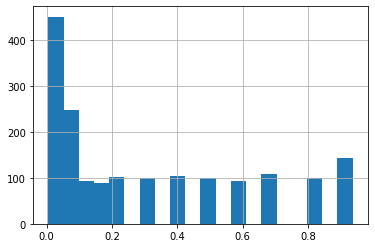

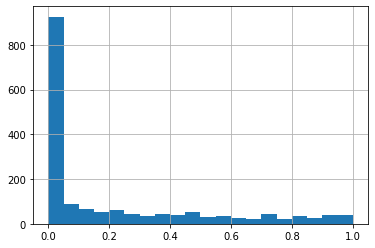

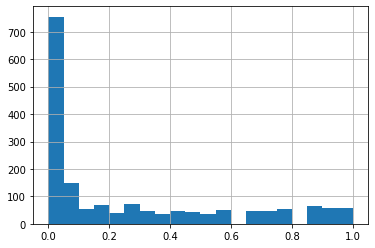

In [123]:
mwr['n'].hist(bins=20)
plt.figure()
mwr['i'].hist(bins=20)
plt.figure()
mwr['d'].hist(bins=20)

<AxesSubplot:>

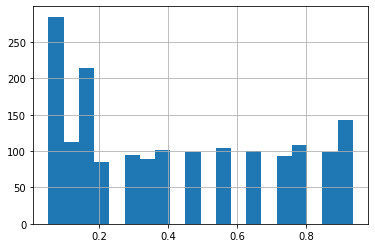

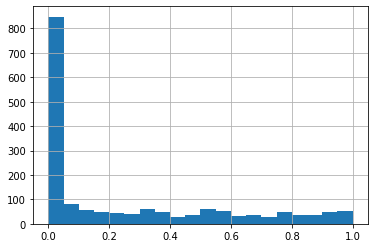

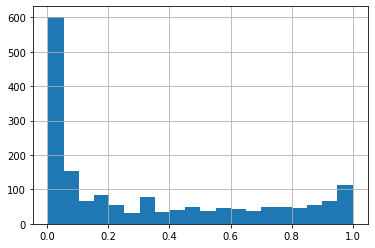

In [124]:
mwr['n_fdr'].hist(bins=20)
plt.figure()
mwr['i_fdr'].hist(bins=20)
plt.figure()
mwr['d_fdr'].hist(bins=20)

In [128]:
mwr.sort_values('d_fdr', ascending=False)

,n,i,d,n_fdr,i_fdr,d_fdr
m_485,0.688921,0.067996,1.000000,0.801189,0.121814,1.000000
l_475,0.936186,0.868226,1.000000,0.936186,0.909294,1.000000
l_198,0.575174,0.900971,1.000000,0.721369,0.930052,1.000000
l_127,0.810181,0.319506,1.000000,0.883323,0.438622,1.000000
l_69,0.575174,0.480731,1.000000,0.721369,0.588810,1.000000
...,...,...,...,...,...,...
m_257,0.030639,0.000011,0.000412,0.133283,0.000073,0.003312
m_197,0.005075,0.000009,0.000412,0.053441,0.000066,0.003312
l_282,0.065552,0.000006,0.000412,0.184981,0.000054,0.003312
m_410,0.065552,0.000003,0.000412,0.184981,0.000054,0.003312
